# HW8 Klim Yadrintsev

First off let's take what we have already from the lectures notebook.

In [1]:
# Have to make adjustment due to folder difference

data_location = 'sqlite:///../../../data/data.db'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import pickle

In [3]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [4]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [5]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)
ohlc.shape

(11627, 9)

In [6]:
ohlc.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC


In [7]:
ohlc.describe()

,open,high,low,close,volume,volumeUSD
count,11627.000000,11627.000000,11627.000000,11627.000000,1.162700e+04,1.162700e+04
mean,5708.198992,5737.512791,5676.641523,5706.967946,7.782893e+05,9.847622e+06
std,16518.161143,16599.532113,16430.972527,16514.731530,2.057505e+06,1.769057e+07
min,0.999900,1.000000,0.995100,0.999900,6.713000e+00,1.960784e+03
25%,4.555900,4.611000,4.496050,4.554350,2.565695e+03,9.664755e+05
50%,92.590000,93.710000,91.000000,92.600000,4.624230e+04,3.420994e+06
75%,307.924500,309.700000,305.501000,307.796500,1.768436e+05,1.068309e+07
max,68638.470000,69000.000000,68456.500000,68639.630000,3.978895e+07,3.988035e+08


## Data Formating

I will also be using formating and converting the table into the fat table, but I wanna add more features to the actual data frame itself.

In [8]:
tokens = ohlc.token.unique()

In [9]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df).fillna(0),
            ret=df.close.pct_change(),
            volume=df.volume
        )[['ts', 'vol', 'ret', 'volume']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'ret', 'volume'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

In [10]:
X.head()

,vol_BTC,ret_BTC,volume_BTC,vol_ETH,ret_ETH,volume_ETH,vol_USDT,ret_USDT,volume_USDT,vol_SOL,...,volume_ATOM,vol_CRV,ret_CRV,volume_CRV,vol_AAVE,ret_AAVE,volume_AAVE,vol_COMP,ret_COMP,volume_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-11-01 00:00:00,0.0,NaN,256.433869,0.0,NaN,4406.453807,0.0,NaN,1443044.08,0.0,...,71933.3,0.0,NaN,107439.71,0.0,NaN,467.302,0.0,NaN,2316.913
2021-11-01 01:00:00,0.0,0.004357,332.481185,0.0,0.006874,8189.769397,0.0,0.0000,1966890.86,0.0,...,93434.7,0.0,0.000725,249880.26,0.0,0.008043,2421.882,0.0,-0.002281,1366.804
2021-11-01 02:00:00,0.0,-0.004508,314.250720,0.0,-0.005322,4866.479502,0.0,-0.0002,2381051.29,0.0,...,147681.1,0.0,-0.031791,373119.36,0.0,-0.009171,737.288,0.0,-0.006020,2771.400
2021-11-01 03:00:00,0.0,-0.012132,1059.931358,0.0,-0.013126,13426.940129,0.0,0.0001,2741940.57,0.0,...,193081.8,0.0,-0.010431,706529.59,0.0,-0.013301,2382.998,0.0,-0.022273,3615.275
2021-11-01 04:00:00,0.0,-0.010186,621.419878,0.0,-0.010679,8460.070019,0.0,0.0000,1699905.28,0.0,...,74836.2,0.0,0.004514,250157.22,0.0,-0.016452,1653.940,0.0,-0.024002,2391.802


In [11]:
X.shape

(1057, 33)

In [12]:
X.tail()

,vol_BTC,ret_BTC,volume_BTC,vol_ETH,ret_ETH,volume_ETH,vol_USDT,ret_USDT,volume_USDT,vol_SOL,...,volume_ATOM,vol_CRV,ret_CRV,volume_CRV,vol_AAVE,ret_AAVE,volume_AAVE,vol_COMP,ret_COMP,volume_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-12-14 20:00:00,0.136358,0.004810,783.748050,0.158369,0.005961,6225.222234,0.002463,0.0001,1826007.47,0.216740,...,37818.6,0.255464,0.003049,139451.07,0.207758,0.009387,2587.093,0.284268,0.006813,628.699
2021-12-14 21:00:00,0.142237,0.019797,1634.610294,0.170096,0.016737,13584.425784,0.002652,0.0000,2628265.46,0.218492,...,96096.0,0.263456,0.021277,152181.31,0.222014,0.022490,5118.783,0.281497,0.017473,2453.455
2021-12-14 22:00:00,0.151148,0.010414,1804.082095,0.172081,0.004623,13031.590980,0.002684,0.0000,3681619.88,0.246122,...,90174.7,0.270895,0.023810,195984.24,0.220598,0.006242,2927.462,0.275083,0.009868,2086.017
2021-12-14 23:00:00,0.149424,-0.000302,675.097958,0.170257,-0.003195,7395.060289,0.002823,0.0001,4247904.90,0.238235,...,28112.9,0.268758,-0.011628,99262.52,0.219474,-0.003013,1650.210,0.271229,-0.000864,416.028
2021-12-15 00:00:00,0.143079,-0.001448,106.582858,0.159883,-0.000641,2453.609904,0.002816,0.0000,638666.74,0.228867,...,15688.5,0.242546,-0.002941,12516.48,0.213360,0.001659,3136.433,0.246067,-0.001027,335.307


In [13]:
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]

In [14]:
X.shape

(1056, 33)

In [15]:
y.shape

(1056,)

In [16]:
y.describe()

count    1056.000000
mean       -0.000156
std         0.012010
min        -0.053429
25%        -0.007444
50%        -0.000503
75%         0.006740
max         0.048298
Name: ret_SOL, dtype: float64

In [17]:
from pandas.plotting import scatter_matrix, autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

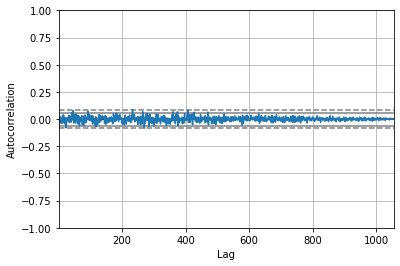

In [18]:
autocorrelation_plot(y[1:])

In [19]:
X.head()

,vol_BTC,ret_BTC,volume_BTC,vol_ETH,ret_ETH,volume_ETH,vol_USDT,ret_USDT,volume_USDT,vol_SOL,...,volume_ATOM,vol_CRV,ret_CRV,volume_CRV,vol_AAVE,ret_AAVE,volume_AAVE,vol_COMP,ret_COMP,volume_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-11-01 00:00:00,0.0,NaN,256.433869,0.0,NaN,4406.453807,0.0,NaN,1443044.08,0.0,...,71933.3,0.0,NaN,107439.71,0.0,NaN,467.302,0.0,NaN,2316.913
2021-11-01 01:00:00,0.0,0.004357,332.481185,0.0,0.006874,8189.769397,0.0,0.0000,1966890.86,0.0,...,93434.7,0.0,0.000725,249880.26,0.0,0.008043,2421.882,0.0,-0.002281,1366.804
2021-11-01 02:00:00,0.0,-0.004508,314.250720,0.0,-0.005322,4866.479502,0.0,-0.0002,2381051.29,0.0,...,147681.1,0.0,-0.031791,373119.36,0.0,-0.009171,737.288,0.0,-0.006020,2771.400
2021-11-01 03:00:00,0.0,-0.012132,1059.931358,0.0,-0.013126,13426.940129,0.0,0.0001,2741940.57,0.0,...,193081.8,0.0,-0.010431,706529.59,0.0,-0.013301,2382.998,0.0,-0.022273,3615.275
2021-11-01 04:00:00,0.0,-0.010186,621.419878,0.0,-0.010679,8460.070019,0.0,0.0000,1699905.28,0.0,...,74836.2,0.0,0.004514,250157.22,0.0,-0.016452,1653.940,0.0,-0.024002,2391.802


In [20]:
pd.isnull(X).sum()

vol_BTC        0
ret_BTC        1
volume_BTC     0
vol_ETH        0
ret_ETH        1
volume_ETH     0
vol_USDT       0
ret_USDT       1
volume_USDT    0
vol_SOL        0
ret_SOL        1
volume_SOL     0
vol_ADA        0
ret_ADA        1
volume_ADA     0
vol_DOT        0
ret_DOT        1
volume_DOT     0
vol_AVAX       0
ret_AVAX       1
volume_AVAX    0
vol_ATOM       0
ret_ATOM       1
volume_ATOM    0
vol_CRV        0
ret_CRV        1
volume_CRV     0
vol_AAVE       0
ret_AAVE       1
volume_AAVE    0
vol_COMP       0
ret_COMP       1
volume_COMP    0
dtype: int64

In [21]:
{col: y.corr(X[col]) for col in X.columns if X[col].dtype != 'object'}

{'vol_BTC': 0.028693550573573316,
 'ret_BTC': -0.013848623804147297,
 'volume_BTC': -0.017489398659781635,
 'vol_ETH': 0.02357151289469286,
 'ret_ETH': 0.03064921265933825,
 'volume_ETH': -0.0046311735593583215,
 'vol_USDT': 0.006850180191310921,
 'ret_USDT': -0.044400854990527476,
 'volume_USDT': -0.005482072192189588,
 'vol_SOL': 0.03485259726638474,
 'ret_SOL': -0.02985506419340651,
 'volume_SOL': -0.017234790442534512,
 'vol_ADA': 0.03888023343700741,
 'ret_ADA': 0.0002492833396142092,
 'volume_ADA': 0.007727906348465451,
 'vol_DOT': 0.059040768451671846,
 'ret_DOT': 0.008193946995455023,
 'volume_DOT': -0.0025886384978023036,
 'vol_AVAX': 0.04140851156078151,
 'ret_AVAX': 0.01691945028976708,
 'volume_AVAX': 0.002919506967847113,
 'vol_ATOM': -0.0022346077856851623,
 'ret_ATOM': 0.05546161881659775,
 'volume_ATOM': -0.039486826377425295,
 'vol_CRV': 0.019828890149893363,
 'ret_CRV': -0.005844145396121401,
 'volume_CRV': -0.02356677130326409,
 'vol_AAVE': 0.03605077807280678,
 'ret

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn import linear_model

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [23]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]


In [24]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])
    
#     scores = []
#     for train_idx, test_idx in cv.split(X):
#         X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
#         model.fit(X_train, y_train)
#         score = mean_squared_error(y_test, model.predict(X_test), squared=False)
#         scores.append(score)
        
#     return np.mean(scores)

## Goal is to beat the model that we have made in class

The score for it was **(-0.008575141851714435)**

In [25]:
best_score_to_beat = -0.008575141851714435

In [26]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('pca', PCA(n_components=1)),
    ('model', Ridge(alpha=1.))
])

evaluate_model(pipeline, X, y)

-0.00857597753146377

In [27]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Ridge())
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': [1, 5, 10, 20, 22, 30],
    'model__alpha': [0.1, 0.5,  1.]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scale', StandardScaler()),
                                       ('pca', PCA()), ('model', Ridge())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 0.5, 1.0],
                         'pca__n_components': [1, 5, 10, 20, 22, 30]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [28]:
search.best_params_

{'model__alpha': 1.0, 'pca__n_components': 1}

In [29]:
best_model = search.best_estimator_

In [30]:
evaluate_model(best_model, X, y)

-0.008584664226524935

### Needs to be less than(-0.008575141851714435)

In [31]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', linear_model.Lasso())
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': [1, 5, 10, 20, 22, 30],
    'model__alpha': [0.1, 0.5,  1.]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scale', StandardScaler()),
                                       ('pca', PCA()), ('model', Lasso())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 0.5, 1.0],
                         'pca__n_components': [1, 5, 10, 20, 22, 30]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [32]:
search.best_params_

{'model__alpha': 0.1, 'pca__n_components': 1}

In [33]:
best_model = search.best_estimator_

In [34]:
evaluate_model(best_model, X, y)

-0.008570816681474391

In [35]:
evaluate_model(best_model, X, y) > best_score_to_beat 

True

# Okay so I have beaten the score of the class result but by not much really

In [36]:
(1 - (evaluate_model(best_model, X, y)/best_score_to_beat)) *100

0.05043846871383151

Only by 0.05% I think that I can do better

### Additional tunning

In [86]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', linear_model.HuberRegressor())
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': [1, 5, 10, 20],
    # 'model__alpha': [0.1, 0.25, 0.5,  1.],
    # 'model__power': [0, 1, 2,  3],
    # 'model__l1_ratio': [0.1, 0.25, 0.5,  1.]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scale', StandardScaler()),
                                       ('pca', PCA()),
                                       ('model', SGDRegressor())]),
             n_jobs=-1, param_grid={'pca__n_components': [1, 5, 10, 20]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [87]:
search.best_params_

{'pca__n_components': 10}

In [88]:
best_model = search.best_estimator_

In [89]:
evaluate_model(best_model, X, y)

-0.008628845623136422

In [90]:
evaluate_model(best_model, X, y) > best_score_to_beat 

False

In [91]:
((1 - (evaluate_model(best_model, X, y)/best_score_to_beat)) *100)

-2.422421462667468